In [26]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

from yellowbrick.text import FreqDistVisualizer
from nltk.corpus import stopwords
import requests
import time
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

In [6]:
# def get_reddit_posts(subreddit, pages):
subreddit = 'fitness'
pages = 40
url = "https://www.reddit.com/r/" + subreddit + ".json"
headers = {'User-agent':'Time Bandit'}
after = None
posts = []
for j in range(pages):
    if after==None:
        params = {}
    else:
        params = {'after':after}
#     print(j)  # just to keep track of progress while it is running
    res = requests.get(url,params=params, headers=headers)
    if res.status_code==200:
        the_json = res.json()
        for i in range(len(the_json['data']['children'])):
            posts.append({'subreddit': the_json['data']['children'][i]['data']['subreddit'],
                              'name':the_json['data']['children'][i]['data']['name'],
                              'title':the_json['data']['children'][i]['data']['title'],
                          'text':the_json['data']['children'][i]['data']['selftext'],
                          'url':the_json['data']['children'][i]['data']['url'],
                             'is_self': the_json['data']['children'][i]['data']['is_self']})
        after = the_json['data']['after']
    else:
        print(res.status_code)
        break
    time.sleep(1)
df = pd.DataFrame(posts)    

In [8]:
df.to_pickle('fitness.pkl')

In [7]:
df.shape

(987, 6)

In [11]:
df_fitness = pd.read_pickle('./fitness.pkl')

In [12]:
df_finance = pd.read_pickle('./finance.pkl')

In [13]:
df = pd.concat([df_fitness, df_finance])
df = df.reset_index(drop=True)
df.subreddit.value_counts()

personalfinance    989
Fitness            987
Name: subreddit, dtype: int64

In [14]:
# Data Cleaning
# Binarize label column
df['fitness'] = df['subreddit'].apply(lambda x: 1 if x == 'Fitness' else 0)

# get rid of \n  and &amp in text
df['text'] = df['text'].map(lambda x: x.replace('\n',' '))

df['text'] = df['text'].map(lambda x: x.replace('&amp;','and'))

In [15]:
# Load stopwords from NLTK and add custom words
mystopwords = stopwords.words('english')
mystopwords.extend(['like','would','get','x200b','https','one','www','com','org','etc','know'])

In [16]:
X = df['text']  # X will be turned into a matrix
y = df['fitness']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [17]:
# Logistic Regression model with Count Vectorizer
cvec = CountVectorizer(stop_words=mystopwords,max_features=None, ngram_range=(1,1))

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

lr = LogisticRegression(penalty='l2',solver='liblinear',C=1)

lr.fit(X_train_cvec, y_train)

print('Logistic Regression model with Count Vectorizer')
# Training score
print(f'Train score: {lr.score(X_train_cvec, y_train):.3f}')

# Test score
print(f'Test score: {lr.score(X_test_cvec, y_test):.3f}')

Logistic Regression model with Count Vectorizer
Train score: 1.000
Test score: 0.996


In [18]:
# set up X, y for Naive Bayes and SVC Models
X = df[['text']]  # X is a pd Dataframe
y = df['fitness']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [19]:
cvec = CountVectorizer(stop_words=mystopwords,max_features=6000, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.3)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Bernoulli model with Count Vectorizer
Train data accuracy: 0.989
Test data accuracy: 0.996


In [106]:
cvec = CountVectorizer(stop_words=mystopwords,max_features=6000, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=.4)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Multinomial model with Count Vectorizer
Train data accuracy: 0.854
Test data accuracy: 0.796


In [20]:
tvec = TfidfVectorizer(stop_words=mystopwords,max_features=6000, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.3)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Bernoulli model with TF-IDF Vectorizer
Train data accuracy: 0.989
Test data accuracy: 0.996


In [22]:
# SVM model
cvec = CountVectorizer(stop_words=mystopwords,max_features=500, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())
# Instantiate SVM.
svc = svm.SVC(kernel='sigmoid', C = 1.8, gamma = .05) 
# svc = svm.SVC(kernel='rbf', C = 2.5, gamma = .06)  # 69%

# Fit on training data.
svc.fit(X_train_cvec,y_train)

# Score model on the training set.
print('Support Vector Machine model with Count Vectorizer')
print(f'Train data accuracy: {svc.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {svc.score(X_test_cvec,y_test):.3f}')

Support Vector Machine model with Count Vectorizer
Train data accuracy: 0.950
Test data accuracy: 0.935


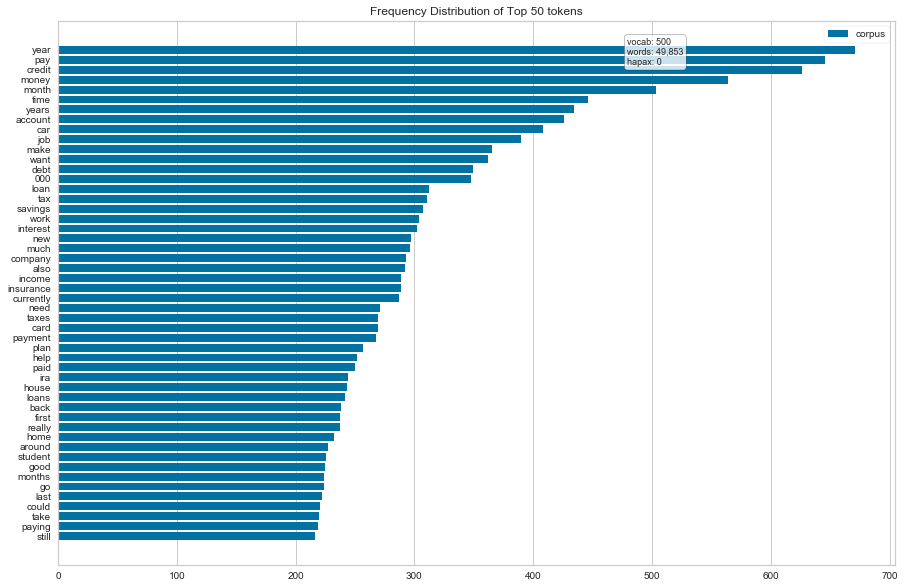

In [23]:
# https://www.scikit-yb.org/en/latest/api/text/freqdist.html
import matplotlib.pyplot as plt
mask       = (df['fitness'] == 0)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features,n=50)
visualizer.fit(docs)
visualizer.poof()

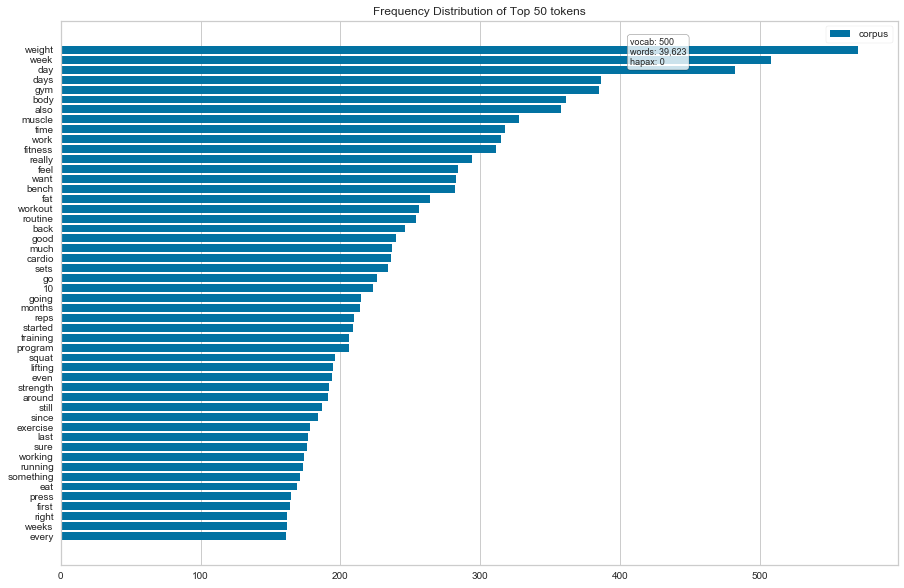

In [24]:
# https://www.scikit-yb.org/en/latest/api/text/freqdist.html
import matplotlib.pyplot as plt
mask       = (df['fitness'] == 1)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features,n=50)
visualizer.fit(docs)
visualizer.poof()

In [83]:
def make_wc(mask):
    # use visualizer to create word frequency list for Wordcloud
    # (it is also possible to let wordcloud create the list)
    docs       = cvec.fit_transform(text for text in df['text'][mask])
    features   = cvec.get_feature_names()
    #create dataframe of word frequencies
    word_freq = pd.DataFrame({'word':features,'freq':list(visualizer.count(docs))})
    word_freq = word_freq.sort_values(by = ['freq'],ascending=False)
    # convert df into dict
    w_dict = dict([(word_freq['word'].iloc[i],word_freq['freq'].iloc[i]) for i in range(len(word_freq))])
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width=500,height=300,scale=2,background_color="white").generate_from_frequencies(w_dict)
    # Display the generated image:
    plt.rcParams['figure.figsize'] = (16.0, 9.0)
    fig = plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    return fig
    

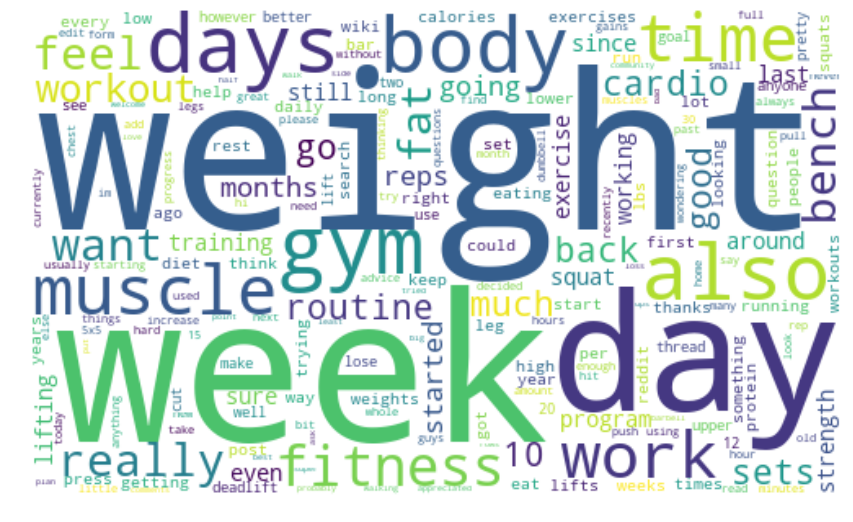

In [80]:
mask = (df['fitness'] == 1)  # select which subreddit to use
name = 'fitness'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png');

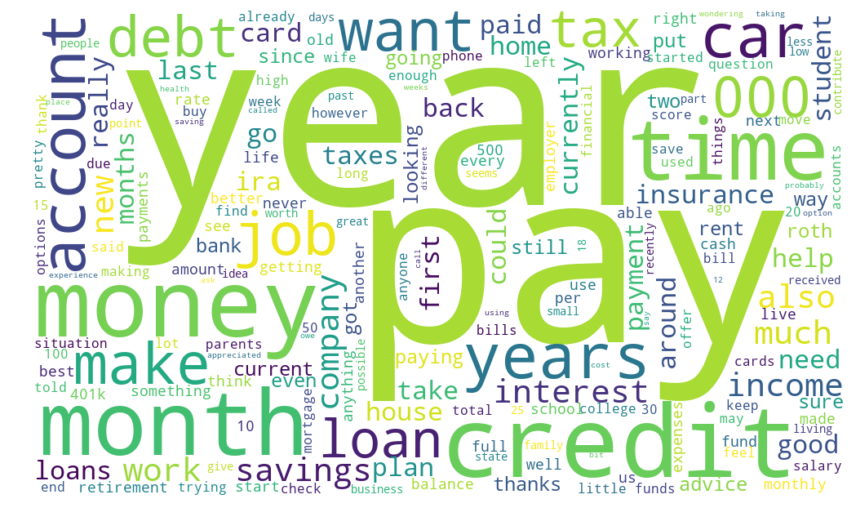

In [84]:
mask = (df['fitness'] == 0)  # select which subreddit to use
name = 'finance'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png');